# Importaciones

In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
import matplotlib.pyplot as plt
import joblib



# Cargar y explorar los datos

In [3]:
orders_df = pd.read_csv('ecommerce_data/train/df_Orders.csv')
items_df = pd.read_csv('ecommerce_data/train/df_OrderItems.csv')
customers_df = pd.read_csv('ecommerce_data/train/df_Customers.csv')
payments_df = pd.read_csv('ecommerce_data/train/df_Payments.csv')
products_df = pd.read_csv('ecommerce_data/train/df_Products.csv')

In [4]:
print(orders_df.head())
# print(items_df.head())
# print(customers_df.head())
# print(payments_df.head())
# print(products_df.head())

       order_id   customer_id order_status order_purchase_timestamp  \
0  Axfy13Hk4PIk  hCT0x9JiGXBQ    delivered      2017-10-22 18:57:54   
1  v6px92oS8cLG  PxA7fv9spyhx    delivered      2018-06-20 21:40:31   
2  Ulpf9skrhjfm  g3nXeJkGI0Qw    delivered      2018-02-16 16:19:31   
3  bwJVWupf2keN  EOEsCQ6QlpIg    delivered      2018-08-18 18:04:29   
4  Dd0QnrMk9Cj5  mVz5LO2Vd6cL    delivered      2017-12-22 16:44:04   

     order_approved_at order_delivered_timestamp order_estimated_delivery_date  
0  2017-10-22 19:14:13       2017-10-26 22:19:52                    2017-11-09  
1  2018-06-20 22:20:20       2018-07-03 22:51:22                    2018-07-24  
2  2018-02-17 16:15:35       2018-02-27 01:29:50                    2018-03-08  
3  2018-08-18 18:15:16       2018-08-27 20:03:51                    2018-09-19  
4  2017-12-22 17:31:31       2018-01-05 19:22:49                    2018-01-18  


In [5]:
# Unir las tablas
df = pd.merge(orders_df, items_df, on='order_id')
df = pd.merge(df, customers_df, on='customer_id')
df = pd.merge(df, payments_df, on='order_id')
df = pd.merge(df, products_df, on='product_id')
print(df.head())

       order_id   customer_id order_status order_purchase_timestamp  \
0  Axfy13Hk4PIk  hCT0x9JiGXBQ    delivered      2017-10-22 18:57:54   
1  Axfy13Hk4PIk  hCT0x9JiGXBQ    delivered      2017-10-22 18:57:54   
2  Axfy13Hk4PIk  hCT0x9JiGXBQ    delivered      2017-10-22 18:57:54   
3  Axfy13Hk4PIk  hCT0x9JiGXBQ    delivered      2017-10-22 18:57:54   
4  Axfy13Hk4PIk  hCT0x9JiGXBQ    delivered      2017-10-22 18:57:54   

     order_approved_at order_delivered_timestamp  \
0  2017-10-22 19:14:13       2017-10-26 22:19:52   
1  2017-10-22 19:14:13       2017-10-26 22:19:52   
2  2017-10-22 19:14:13       2017-10-26 22:19:52   
3  2017-10-22 19:14:13       2017-10-26 22:19:52   
4  2017-10-22 19:14:13       2017-10-26 22:19:52   

  order_estimated_delivery_date    product_id     seller_id   price  ...  \
0                    2017-11-09  90K0C1fIyQUf  ZWM05J9LcBSF  223.51  ...   
1                    2017-11-09  90K0C1fIyQUf  ZWM05J9LcBSF  223.51  ...   
2                    2017-11-09 

In [6]:
# Calcular la duracion total de la entrega en horas:
# 'order_delivered_timestamp' - 'order_purchase_timestamp'
df['delivery_duration'] = (pd.to_datetime(df['order_delivered_timestamp']) - 
                           pd.to_datetime(df['order_purchase_timestamp'])).dt.total_seconds() / 3600
print(df['delivery_duration'].head())

0    99.366111
1    99.366111
2    99.366111
3    99.366111
4    99.366111
Name: delivery_duration, dtype: float64


In [7]:
# Creacion de variables de tiempo
df['order_day_of_week'] = pd.to_datetime(df['order_purchase_timestamp']).dt.dayofweek
df['order_month'] = pd.to_datetime(df['order_purchase_timestamp']).dt.month
df['order_hour'] = pd.to_datetime(df['order_purchase_timestamp']).dt.hour
print(df['order_day_of_week'].head())
print('--------------------------')
print(df['order_month'].head())
print('--------------------------')
print(df['order_hour'].head())

0    6
1    6
2    6
3    6
4    6
Name: order_day_of_week, dtype: int32
--------------------------
0    10
1    10
2    10
3    10
4    10
Name: order_month, dtype: int32
--------------------------
0    18
1    18
2    18
3    18
4    18
Name: order_hour, dtype: int32


# Limpieza y preparacion de datos

In [8]:
# Eliminar registros nulos o incompletos
df = df.dropna()
# Comprueba si ya no existen registros nulos
print(df.isnull().sum())

order_id                         0
customer_id                      0
order_status                     0
order_purchase_timestamp         0
order_approved_at                0
order_delivered_timestamp        0
order_estimated_delivery_date    0
product_id                       0
seller_id                        0
price                            0
shipping_charges                 0
customer_zip_code_prefix         0
customer_city                    0
customer_state                   0
payment_sequential               0
payment_type                     0
payment_installments             0
payment_value                    0
product_category_name            0
product_weight_g                 0
product_length_cm                0
product_height_cm                0
product_width_cm                 0
delivery_duration                0
order_day_of_week                0
order_month                      0
order_hour                       0
dtype: int64


In [9]:
# Selecciona las variables predictoras
features = ['price', 'shipping_charges', 
            'product_weight_g', 'order_day_of_week', 
            'order_month', 'order_hour', 'customer_state']

X = df[features]
# Se desea conocer la duracion del envio
y = df['delivery_duration']
# One-Hot Encoding para las variables categóricas
X = pd.get_dummies(X, columns=['customer_state'])
# print(X.head())

In [20]:
# Dividir el conjunto de datos en entrenamiento y validacion
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


# Modelo de machine learning

In [38]:
# Entrenar el modelo
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [43]:
# Evaluar el modelo
y_pred = model.predict(X_val)
print("MAE:", mean_absolute_error(y_val, y_pred))
print("RMSE:", root_mean_squared_error(y_val, y_pred))


MAE: 2.3597167172806426
RMSE: 21.89904009541277


### Guardar o cargar el modelo

In [46]:
# Para guardar el modelo
joblib.dump(model, 'modelo_entrenado.pkl')

['modelo_entrenado.pkl']

In [11]:
# Cargar el modelo desde el archivo
modelo_cargado = joblib.load('modelo_entrenado.pkl')

# Usar el modelo cargado para hacer predicciones
predicciones = modelo_cargado.predict(X_val)


# Visualizar predicciones

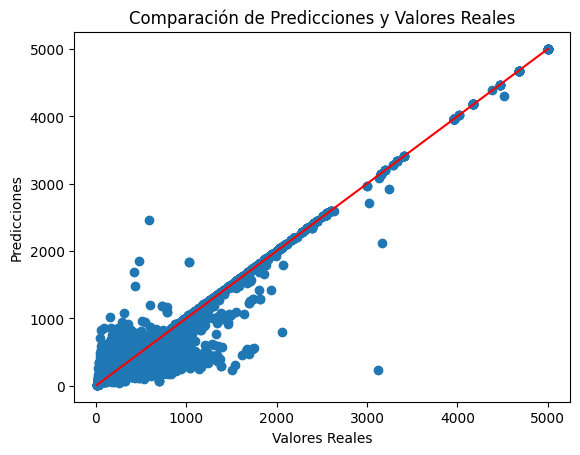

In [21]:
# Grafico de dispersion entre valores reales y predicciones
plt.scatter(y_val, predicciones)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Comparación de Predicciones y Valores Reales')
# Línea de referencia
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], color='red')
plt.show()
